<a href="https://colab.research.google.com/github/tmorshed/dbs_cep/blob/master/cep_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing cortical evoked potentials (cEPs) in STN-DBS
#### by Taha Morshedzadeh. **Krembil Research Institute, UHN. Toronto, Canada**

*This work is done as a part of the HMB496 "Independent Project in Human Biology" i.e. undergraduate thesis at the University of Toronto during Fall-Winter semesters of the 2019-20 year.*




In this Jupyter, we will try to estimate the cortical evoked potentials using EEG as a result of Deep Brain Stimulation in the Subthalamic Nucleus (STN). We will use the package `mne` from the Martinos Centre found at [this link](https://mne.tools). This package automatically sets matplotlib to `Qt` but since we are on Colab and it does not yet support `Qt`, we make it `inline` so that it appears as any other normal output in the notebook below the code snippet.


![MNE](https://mne.tools/stable/_static/mne_logo.png)

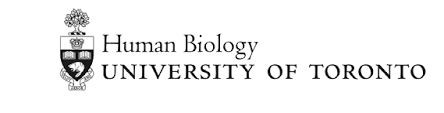


In [2]:
!pip install mne

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### a) import packages and files:

In [0]:
  #import os
    
%reset -sf

import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy.signal as sg
from datetime import datetime
%matplotlib inline

In [0]:
raw = mne.io.read_raw_cnt(r"/content/drive/My Drive/research/nsbspl/data/130Hz_STN_OFF_LeftSTIM.cnt", preload=False)
#preload=True makes it load to RAM as well. Normally, it only loads the symlinks to the RAM and the data stays in the local storage

the imported data object has 913600 time samples and 59 channels.
The last time sample is at 182.7198 seconds.

sampling frequency is 5000.0
MISC INFO: None
<Info | 8 non-empty values
 bads: []
 ch_names: L0, L1, L2, L3, R0, R1, R2, R3, FT7, FC5, FC3, FC1, FCZ, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: 2018-09-03 12:33:57 UTC
 nchan: 59
 projs: []
 sfreq: 5000.0 Hz
 subject_info: 5 items (dict)
>




The sensor locations on the cranium:


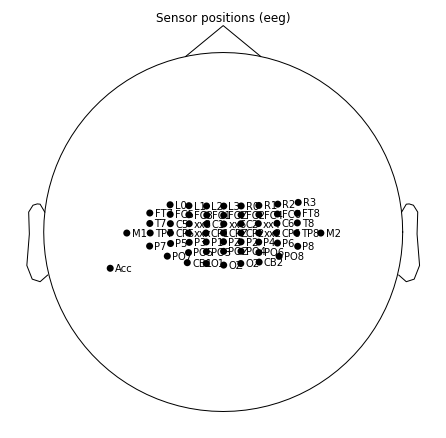

The sensor locations in 3D:


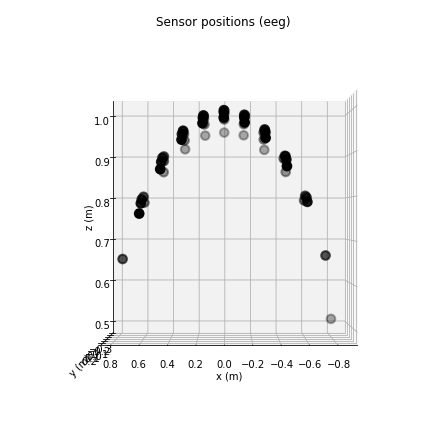

Reading 0 ... 913599  =      0.000 ...   182.720 secs...
We will use the timewindow of 0.0 to 10.0 seconds.
this is equal to 10000.0 milliseconds in length
this is equal to 50000 datapoints in length


In [25]:
##Choose channel to analyze                                                     #Please input the desired channel name
ch_choice = ['L2']
#Choose the times below. We will crop the file in this  window.
time_secs = raw.times
start_stop_seconds = np.array([time_secs[0], 10])                               #Please select start and end crop times in seconds


##Import metadata to internal variables
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)
sampling_rate= raw.info['sfreq']
dt=1/sampling_rate

#finds the index for the chosen channel
ranger=np.arange(1,n_chan);
for i in ranger:
  if ch_names[i]==ch_choice[0]:
       index_channel=i
  else:
       pass

## Print some metadata
print('the imported data object has {} time samples and {} channels.'
''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print()  # insert a blank line in the output
print('sampling frequency is {}'.format(sampling_rate, 'Hz'))           
print('MISC INFO: {}'.format(raw.info['description'], '\n')) #misc  info

print(raw.info)
print() #adding an extra row 
print() 
print()
print()

print('The sensor locations on the cranium:')
raw.plot_sensors(show_names=True)
print('The sensor locations in 3D:')
raw.plot_sensors('3d')

#Cropping the file
raw_select = raw.copy().load_data()
raw_select.crop(tmin=start_stop_seconds[0], tmax=start_stop_seconds[1], include_tmax=True);
raw_select.pick_channels(ch_choice);
#start_sample, stop_sample = (start_stop_seconds * sampling_rate).astype(int)
times=np.arange(start_stop_seconds[0],start_stop_seconds[1],dt)

#extracting some internal variables from above input
duration_selection = start_stop_seconds[1]-start_stop_seconds[0]
start_sample, stop_sample = (start_stop_seconds * sampling_rate).astype(int)
times=np.arange(start_stop_seconds[0],start_stop_seconds[1],dt)
lsel=len(times)
times=times.reshape(1,lsel)

#printing some metadata
print('We will use the timewindow of {} to {} seconds.'.format(start_stop_seconds[0],start_stop_seconds[1]))
print('this is equal to {} milliseconds in length'.format(duration_selection*1000))
print('this is equal to {} datapoints in length'.format(lsel))

## Importing the selected time window to a Numpy Array:

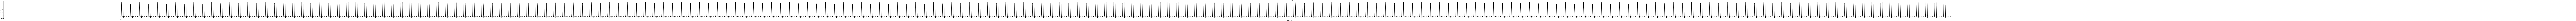

In [30]:
#imports the selected window to a NumPy Array
raw_selection = list(raw[index_channel, start_sample:stop_sample]);
x = raw_selection[1].reshape(lsel,);
y = raw_selection[0].T;
y = np.mean(y) - y
y = y.reshape(lsel,)
#print('Quality control:')
#print(x.shape)
#print(y.shape)


fig = plt.figure();
figwid=100;                                                                     #select the width of the figures
axes=fig.add_axes([0, 0, figwid, 1]);
axes.plot(x, y, c='k');
axes.set_facecolor('white')
axes.set_title('imported time window')
axes.set_ylabel('LFP (mV), mean = 0')
axes.set_xlabel('time (seconds)')
axes.autoscale_view(tight=True)

## Find the peaks:

0.046129797636270516
0.023064898818135258
(1299,)
(1299,)


[[   24     0     0]
 [   63     0     0]
 [  101     0     0]
 ...
 [49918     0     0]
 [49957     0     0]
 [49995     0     0]]


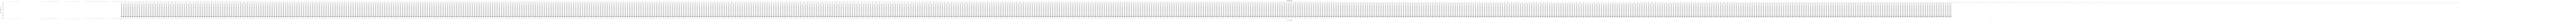

In [34]:
amp_max=max(y)
amp_th=amp_max/2
print(amp_max)
print(amp_th)

pkfinder=sg.find_peaks(y, height=(amp_th))

indx_pks=pkfinder[0]*dt+start_stop_seconds[0]
pks=pkfinder[1]['peak_heights']

print(indx_pks.shape)
print(pks.shape)
print()
#print(indx_pks)
print()
#print(pks)

##Change events into MNE format:

i = np.append(pkfinder[0].reshape(len(indx_pks),1), np.zeros((len(indx_pks),2), int), axis=1)
print(i)


fig = plt.figure();
#plt.savefig(fname='/content/drive/My Drive/research/nsbspl/figures/cep/{}_selected_window.png'.format(datetime.now()))
axes=fig.add_axes([1, 1, figwid, 1]);
axes.plot(x, y, c='k');
axes.scatter(indx_pks, pks, marker='x', c='maroon')
axes.set_title('detected peaks')
axes.set_facecolor('white')
axes.set_ylabel('LFP in mV, mean = 0')
axes.set_xlabel('time, in seconds')
axes.autoscale_view(tight=True, scalex=True, scaley=True)